# Sentiment Analysis Tool (IMDB) — Colab Notebook
**Author:** Yogitha

**Date:** 2025-12-09  
**Goal:** Train a TF-IDF + Logistic Regression model for binary sentiment classification (IMDB). Save model & vectorizer to Google Drive.

In [1]:
!pip install --quiet scikit-learn pandas joblib datasets nltk

In [2]:
from google.colab import drive
drive.mount('/content/drive')

ARTIFACTS_DIR = '/content/drive/MyDrive/sentiment_project/artifacts'
import os
os.makedirs(ARTIFACTS_DIR, exist_ok=True)
print("Artifacts will be saved to:", ARTIFACTS_DIR)


Mounted at /content/drive
Artifacts will be saved to: /content/drive/MyDrive/sentiment_project/artifacts


In [3]:
from datasets import load_dataset
dataset = load_dataset('imdb')   # official IMDB dataset (train + test)
print(dataset)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [4]:
import pandas as pd, re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import joblib
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOP = set(stopwords.words('english'))

def clean_text(s):
    s = str(s).lower()
    s = re.sub(r'http\S+|www\S+|https\S+', '', s)     # remove urls
    s = re.sub(r'[^a-z0-9\s]', ' ', s)                # remove punct
    tokens = s.split()
    tokens = [t for t in tokens if t not in STOP]
    return " ".join(tokens)

# convert HF dataset to pandas
train_df = pd.DataFrame(dataset['train'])
test_df  = pd.DataFrame(dataset['test'])
df = pd.concat([train_df, test_df]).sample(frac=1, random_state=42).reset_index(drop=True)
df = df[['text','label']].dropna()
df['text_clean'] = df['text'].apply(clean_text)

X = df['text_clean'].values
y = df['label'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
Xtr = tfidf.fit_transform(X_train)
Xv = tfidf.transform(X_val)

model = LogisticRegression(max_iter=1000)
model.fit(Xtr, y_train)

# Evaluate
y_pred = model.predict(Xv)
acc = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
print("Accuracy:", acc)
print("F1 score:", f1)
print(classification_report(y_val, y_pred))

# Save artifacts to Drive
joblib.dump(tfidf, ARTIFACTS_DIR + '/tfidf_vectorizer.joblib')
joblib.dump(model, ARTIFACTS_DIR + '/sentiment_model.joblib')
print("Saved vectorizer + model to:", ARTIFACTS_DIR)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Accuracy: 0.8976
F1 score: 0.8986339338744803
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      5000
           1       0.89      0.91      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

Saved vectorizer + model to: /content/drive/MyDrive/sentiment_project/artifacts


In [5]:
import joblib
vec = joblib.load(ARTIFACTS_DIR + '/tfidf_vectorizer.joblib')
model = joblib.load(ARTIFACTS_DIR + '/sentiment_model.joblib')

def predict_text(text):
    text_clean = " ".join([w for w in text.lower().split() if w not in STOP])  # simple clean for demo
    t = vec.transform([text_clean])
    pred = model.predict(t)[0]
    prob = model.predict_proba(t)[0]
    return {"label": "Positive" if pred==1 else "Negative", "proba": prob.tolist()}

examples = [
  "That movie was absolutely amazing, I loved it!",
  "Worst movie ever. So boring and long.",
  "It had some good scenes, but overall meh."
]

for ex in examples:
    print(ex, "->", predict_text(ex))


That movie was absolutely amazing, I loved it! -> {'label': 'Positive', 'proba': [0.056896253040423006, 0.943103746959577]}
Worst movie ever. So boring and long. -> {'label': 'Negative', 'proba': [0.9992816104280907, 0.0007183895719092415]}
It had some good scenes, but overall meh. -> {'label': 'Positive', 'proba': [0.3209871422324936, 0.6790128577675064]}


Saved confusion matrix to: /content/drive/MyDrive/sentiment_project/artifacts/confusion_matrix.png


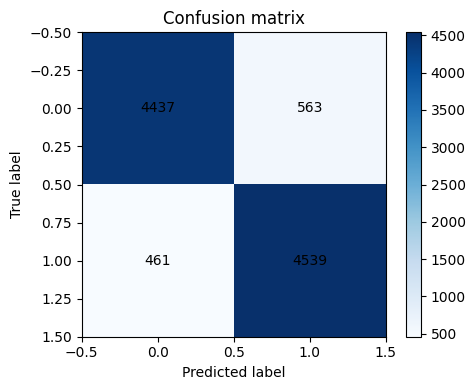

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="black")
plt.tight_layout()
plt.savefig(ARTIFACTS_DIR + '/confusion_matrix.png', bbox_inches='tight')
print("Saved confusion matrix to:", ARTIFACTS_DIR + '/confusion_matrix.png')